In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import json
from pathlib import Path

In [21]:
dataset = "normals"
pred = "stumps-optimal"
bound = "mcallester"
prior = 0.1
lr = 0.01

In [22]:
results = {}
for risk in ["exact"]:
    results[risk] = {}
    for opt in [True, False]:
        results[risk][opt] = {}
        load_dir = Path(f"../results/{dataset}/50/{risk}/{bound}/optimize-bound={opt}/stumps-optimal/M=4/prior={prior}/lr={lr}")
        print(load_dir)
        filename = next(load_dir.rglob(f'**/monitor_scalars.json'))

        with open(filename) as f:
            d = json.load(f)
            for k, item in d.items():
                if "KL" in k:
                    results[risk][opt]['KL'] = np.array(item)[:, 1:]
                elif "posterior/l2" in k:
                    results[risk][opt][r'$||\alpha||_2$'] = np.array(item)[:, 1:]
                elif "posterior/l1" in k:
                    results[risk][opt][r'$||\alpha||_1$'] = np.array(item)[:, 1:]
                elif "post_grad" in k:
                    results[risk][opt]['gradient'] = np.array(item)[:, 1:]
                elif "Train-obj" in k:
                    results[risk][opt]['objective'] = np.array(item)[:, 1:]

../results/normals/50/exact/mcallester/optimize-bound=True/stumps-optimal/M=4/prior=0.1/lr=0.01
../results/normals/50/exact/mcallester/optimize-bound=False/stumps-optimal/M=4/prior=0.1/lr=0.01


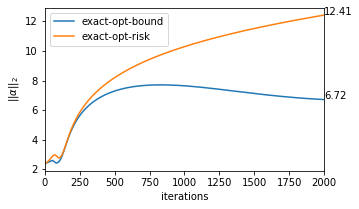

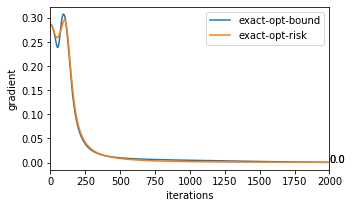

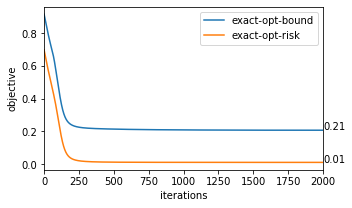

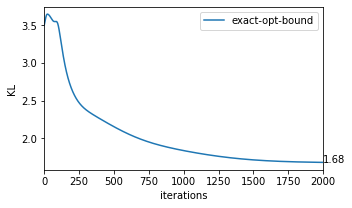

In [23]:
risk = "exact"
it = 2000

for i, metric in enumerate([r'$||\alpha||_2$', 'gradient', 'objective', 'KL']):  
    plt.figure(figsize=(5,3))  

    plt.plot(results[risk][True][metric][:, 0], results[risk][True][metric][:, 1], label=f"{risk}-opt-bound")
    last = round(results[risk][True][metric][-1, 1], 2)
    plt.text(it, last, last)

    if metric != "KL":
        plt.plot(results[risk][False][metric][:, 0], results[risk][False][metric][:, 1], label=f"{risk}-opt-risk")
        last = round(results[risk][False][metric][-1, 1], 2)
        plt.text(it, last, last)

    plt.ylabel(metric)
    plt.xlabel("iterations")
    plt.subplots_adjust(wspace=0.5)
    plt.xlim(0, it)
    plt.legend()
    
    plt.savefig(f"normals-{bound}-{metric}.pdf", bbox_inches="tight")

In [24]:
M = 4
ns = [10, 100, 1000]
ts = [1, 5, 10, 20, 40, 80, 100]
methods = ["exact", "MC"]
bound = "seeger"
seeds = "541713-541723"

load_dir = Path(f"../results/latest/moons/")

results = {}
for n in ns:
    c_dir = load_dir / f"{n}/MC/{bound}/optimize-bound=True/stumps-uniform/M=4/"
    
    results[n] = {}
    results[n]["MC"] = {}
    for t in ts:
        path = next(c_dir.rglob(f"**/seeds={seeds}/MC={t}/*.npy"))
        results[n]["MC"][t] = np.load(path, allow_pickle=True).item()
    
    c_dir = load_dir / f"{n}/exact/{bound}/optimize-bound=True/stumps-uniform/M=4/"
    results[n]["exact"] = {}
    path = next(c_dir.rglob(f"**/seeds={seeds}/*.npy"))
    results[n]["exact"] = np.load(path, allow_pickle=True).item()

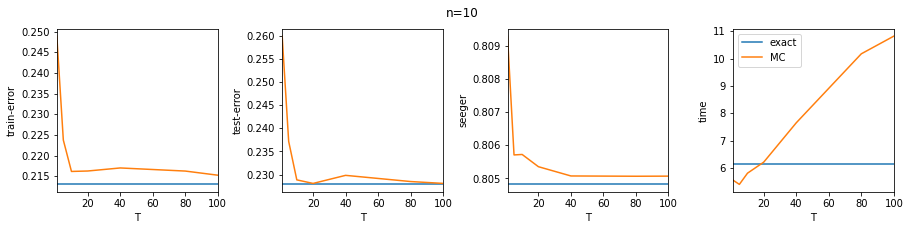

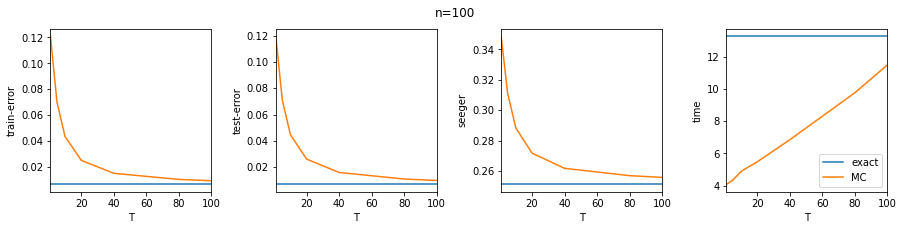

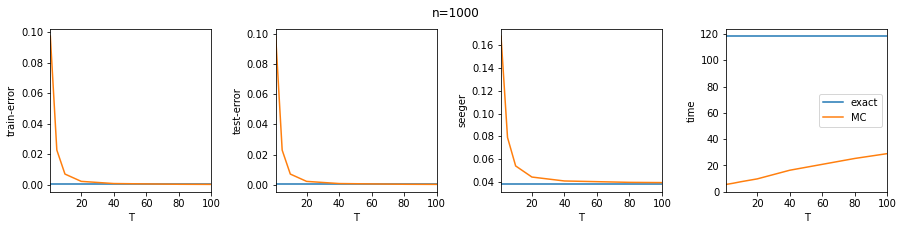

In [3]:
b = "seeger"

for n in ns:
    plt.figure(figsize=(15,3))

    for j, e in enumerate(["train-error", "test-error", b, "time"]):
        ax = plt.subplot(141 + j)

        plt.plot(ts, [results[n]["exact"][e][0]] * len(ts), label="exact")
#         plt.fill_between(ts, [results[n]["exact"][e][0] - results[n]["exact"][e][1]] * len(ts), [results[n]["exact"][e][0] + results[n]["exact"][e][1]] * len(ts), alpha=0.5)

        y = np.array([results[n]["MC"][t][e][0] for t in ts])
        err = np.array([results[n]["MC"][t][e][1] for t in ts])

        plt.plot(ts, y, label="MC")
#         plt.fill_between(ts, y-err, y+err, alpha=0.5)

        plt.xlim(min(ts), max(ts))    
        plt.ylabel(e)
        plt.xlabel("T")

    plt.suptitle(f"n={n}")
    plt.subplots_adjust(wspace=0.4)
    plt.legend()
    
    plt.savefig(f"moons-n={n}-M=4-all-T.pdf", bbox_inches="tight")

In [16]:
ms = [2, 4, 8, 16, 32]
n = 1000
ts = [1, 5, 10, 20, 40, 80, 100]
methods = ["exact", "MC"]
bound = "seeger"
seeds = "541713-541723"

load_dir = Path(f"../results/latest/moons/")

results = {}
for m in ms:
    c_dir = load_dir / f"{n}/MC/{bound}/optimize-bound=True/stumps-uniform/M={m}/"
    
    results[m] = {}
    results[m]["MC"] = {}
    for t in ts:
        path = next(c_dir.rglob(f"**/seeds={seeds}/MC={t}/*.npy"))
        results[m]["MC"][t] = np.load(path, allow_pickle=True).item()
    
    c_dir = load_dir / f"{n}/exact/{bound}/optimize-bound=True/stumps-uniform/M={m}/"
    results[m]["exact"] = {}
    path = next(c_dir.rglob(f"**/seeds={seeds}/*.npy"))
    results[m]["exact"] = np.load(path, allow_pickle=True).item()

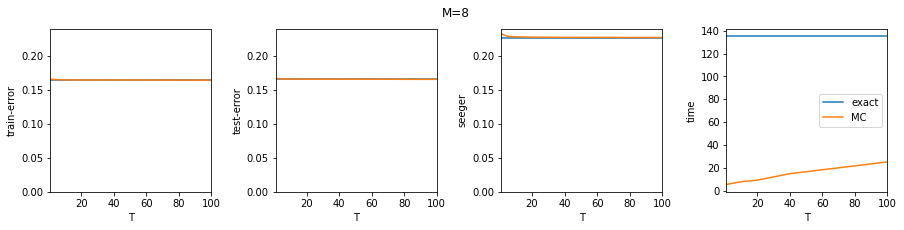

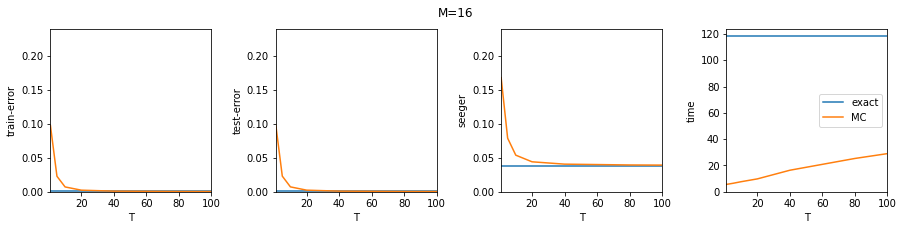

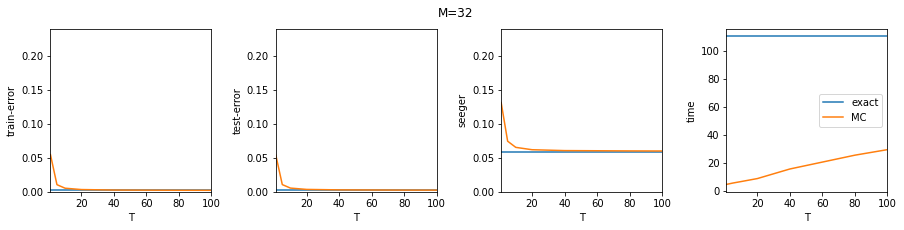

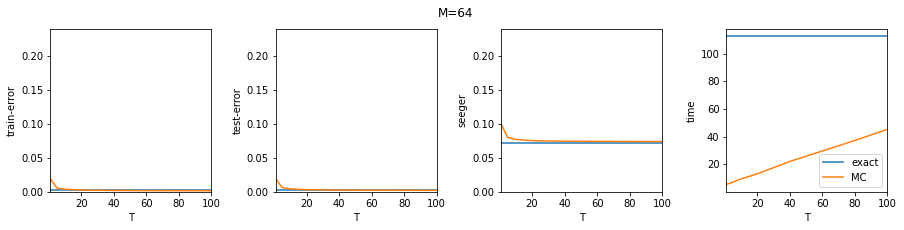

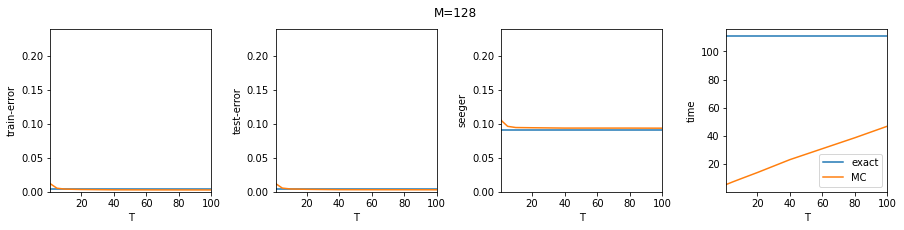

In [18]:
b = "seeger"

for m in ms:
    plt.figure(figsize=(15,3))

    for j, e in enumerate(["train-error", "test-error", b, "time"]):
        ax = plt.subplot(141 + j)

        plt.plot(ts, [results[m]["exact"][e][0]] * len(ts), label="exact")
#         plt.fill_between(ts, [results[n]["exact"][e][0] - results[n]["exact"][e][1]] * len(ts), [results[n]["exact"][e][0] + results[n]["exact"][e][1]] * len(ts), alpha=0.5)

        y = np.array([results[m]["MC"][t][e][0] for t in ts])
        err = np.array([results[m]["MC"][t][e][1] for t in ts])

        plt.plot(ts, y, label="MC")
#         plt.fill_between(ts, y-err, y+err, alpha=0.5)

        plt.xlim(min(ts), max(ts))    
        plt.ylabel(e)
        plt.xlabel("T")
        if e in ["train-error", "test-error", b]:
            plt.ylim(0, 0.24)

    plt.suptitle(f"M={m*4}")
    plt.subplots_adjust(wspace=0.4)
    plt.legend()
    
    plt.savefig(f"moons-n={n}-M={m}-all-T.pdf", bbox_inches="tight")